In [1]:
import FinanceDataReader as fdr

In [2]:
import pandas as pd
import numpy as np
import os
import os.path as osp
import datetime
import shutil
import matplotlib.pyplot as plt

In [21]:
def get_name(symbol, market="KRX"):
    root = "dataset/stock_list"
    
    today = datetime.datetime.now()
    today = datetime.datetime.strftime(today, "%Y_%m_%d")
    
    filename = "stock_list_"+market+"_"+today+".xlsx"
    save_path = osp.join(root, filename)
    
    if not osp.isfile(save_path):
        if osp.exists(root):
            shutil.rmtree(root)
        os.mkdir(root)
        df = fdr.StockListing(market)
        df.set_index("Symbol", inplace=True)
        name = df.loc[symbol, "Name"]
        df.to_excel(save_path)
    
    else:
        df = pd.read_excel(save_path, index_col="Symbol")
        name = df.loc[symbol, "Name"]
        
    return name

In [4]:
def get_exists_excel(symbol, start_date, end_date):
    root = "dataset"
    filename = "_".join([symbol, start_date.replace("-", "_"), end_date.replace("-", "_")]) + ".xlsx"
    save_path = osp.join(root, filename)
    
    if osp.isfile(save_path):
        is_exsists = True
        df = pd.read_excel(save_path, index_col="Date")
        
    else:
        is_exsists = False
        df = None
        
    return is_exsists, df

In [5]:
def save_excel(df, symbol, start_date, end_date):
    if end_date is None:
        end_date = datetime.datetime.now()
        end_date = datetime.datetime.strftime(end_date, "%Y-%m-%d")
        
    root = "dataset"
    if not osp.exists(root):
        os.mkdir(root)
        
    filename = "_".join([symbol, start_date.replace("-", "_"), end_date.replace("-", "_")]) + ".xlsx"
    save_path = osp.join(root, filename)
    df.to_excel(save_path)

In [23]:
def make_dict_beautiful(bought_dict):
    for key, value in bought_dict.items():
        if key in ["종목명", "종목코드"]:
            continue
        suffix = ""
        prefix = ""

        if key in ["매입금액", "평균단가", "현재가", "평가손익"]:
            suffix = "원or달러"

        elif key in ["보유수량"]:
            suffix = "주"

        elif key in ["수익률"]:
            suffix = "%"

        if key in ["수익률", "평가손익"]:
            if value > 0:
                prefix = "+"

        value = prefix+format(value, ",")+suffix
        bought_dict[key] = value
    return bought_dict

In [7]:
def get_monthly_buy_by_num(
    symbol:str="005930", 
    start_date:str=None, 
    end_date:str=None, 
    market:str="KRX", 
    num_buy:int=1,
    show_graph:bool=False,
    fig_save_path:str=None):
    """
        한 달에 1번 지정한 수량만큼 매수
        매달 초에 매수
        
        symbol: 종목번호 혹은 종목티커
        start_date: 조회할 시작 날짜 (입력 안할 시 오늘로부터 30일 이전으로 설정됨)
        start_date: 조회할 끝 날짜 (입력 안할 시 오늘로 설정됨)
        market: KRX (KOSPI, KODAQ, KONEX), NASDAQ, NYSE, AMEX, S&P 500
        num_buy: 한달 매수 수량
        show_graph: 그래프 출력 여부
        fig_save_path: 그래프 저장 경로 (확장자명은 생략)
    """
    name = get_name(symbol, market)
    
    if start_date is None:
        start_date = datetime.datetime.now()
        start_date = start_date - datetime.timedelta(days=30)
        start_date = datetime.datetime.strftime(start_date, "%Y-%m-%d")
        
    if end_date is None:
        end_date = datetime.datetime.now()
        end_date = datetime.datetime.strftime(end_date, "%Y-%m-%d")
        
    is_exsists, df = get_exists_excel(symbol, start_date, end_date)
    if not is_exsists:
        df = fdr.DataReader(symbol, start=start_date, end=end_date)
        save_excel(df, symbol, start_date, end_date)
    try:
        current_price = df["Close"].iloc[-1]
        is_data = True
    except IndexError:
        is_data = False
    
    if is_data:
        scatter_data = dict()
        
        date_list = df.index
        date_year_month_list = [(date.year, date.month) for date in date_list]
        _date, date_index = np.unique(date_year_month_list, axis=0, return_index=True)
        buy_data = df.iloc[date_index]
        bought_dict = {"종목명": name, "종목코드": symbol, "보유수량": 0, "매입금액": 0}
        close_data = buy_data["Close"].to_numpy()
        bought_dict["보유수량"] = len(close_data)*num_buy
        bought_dict["매입금액"] = np.sum(close_data*num_buy)
        for date, close in buy_data["Close"].items():
            scatter_data[date] = close
        try:        
            bought_dict["평균단가"] = int(bought_dict["매입금액"]/bought_dict["보유수량"])
            bought_dict["현재가"] = current_price
            bought_dict["수익률"] = round((bought_dict["현재가"]-bought_dict["평균단가"])/bought_dict["평균단가"]*100, 2)
            bought_dict["평가손익"] = int(bought_dict["매입금액"]*bought_dict["수익률"]/100)
            is_buy = True
        except ZeroDivisionError:
            is_buy = False

        if is_buy: # 그래프와 결과를 출력
            if show_graph:
                fig = plt.figure(figsize=(12, 8))
                plt.plot(df.index, df["Close"], color="k", label="Close")
                plt.scatter(scatter_data.keys(), scatter_data.values(), color="r", marker="o", label="Buy", s=100)
                plt.legend()

            if fig_save_path is not None:
                if not osp.exists("results"):
                    os.mkdir("results")
                plt.savefig("results/{}.jpg".format(fig_save_path))
        bought_dict = make_dict_beautiful(bought_dict)
        return bought_dict

{'종목명': '삼성전자',
 '종목코드': '005930',
 '보유수량': '132주',
 '매입금액': '4,356,390원',
 '평균단가': '33,002원',
 '현재가': '73,600원',
 '수익률': '+123.02%',
 '평가손익': '+5,359,230원'}

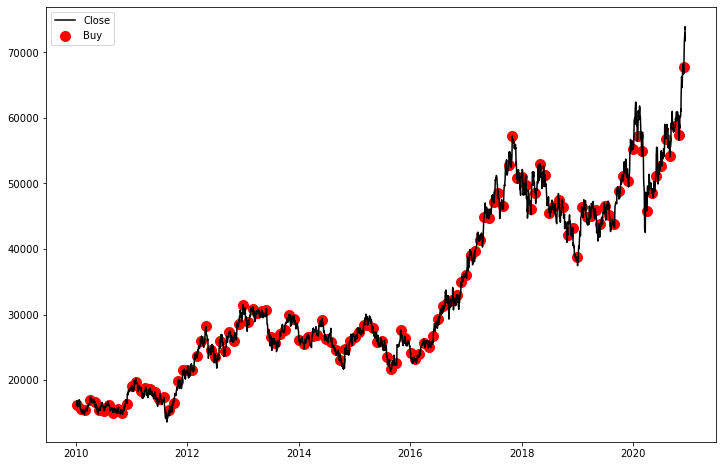

In [11]:
get_monthly_buy_by_num(start_date="2010-01-01", num_buy=1, show_graph=True, fig_save_path="result")

In [12]:
def get_monthly_buy_by_price(
    symbol:str="005930", 
    start_date:str=None, 
    end_date:str=None, 
    market:str="KRX", 
    price_buy:int=60000,
    show_graph:bool=False,
    fig_save_path:str=None):
    """
        한 달에 1번 지정한 수량만큼 매수
        매달 초에 매수
        
        symbol: 종목번호 혹은 종목티커
        start_date: 조회할 시작 날짜 (입력 안할 시 오늘로부터 30일 이전으로 설정됨)
        start_date: 조회할 끝 날짜 (입력 안할 시 오늘로 설정됨)
        market: KRX (KOSPI, KODAQ, KONEX), NASDAQ, NYSE, AMEX, S&P 500
        price_buy: 한달 매수 금액
        show_graph: 그래프 출력 여부
        fig_save_path: 그래프 저장 경로 (확장자명은 생략)
    """
    name = get_name(symbol, market)
    
    if start_date is None:
        start_date = datetime.datetime.now()
        start_date = start_date - datetime.timedelta(days=30)
        start_date = datetime.datetime.strftime(start_date, "%Y-%m-%d")
        
    if end_date is None:
        end_date = datetime.datetime.now()
        end_date = datetime.datetime.strftime(end_date, "%Y-%m-%d")
        
    is_exsists, df = get_exists_excel(symbol, start_date, end_date)
    if not is_exsists:
        df = fdr.DataReader(symbol, start=start_date, end=end_date)
        save_excel(df, symbol, start_date, end_date)
    try:
        current_price = df["Close"].iloc[-1]
        is_data = True
    except IndexError:
        is_data = False
    
    if is_data:
        scatter_data = dict()
        
        date_list = df.index
        date_year_month_list = [(date.year, date.month) for date in date_list]
        _date, date_index = np.unique(date_year_month_list, axis=0, return_index=True)
        buy_data = df.iloc[date_index]
        bought_dict = {"종목명": name, "종목코드": symbol, "보유수량": 0, "매입금액": 0}
        close_data = buy_data["Close"].to_numpy()
        num_buy = price_buy // close_data
        bought_dict["보유수량"] = np.sum(num_buy)
        bought_dict["매입금액"] = np.sum(close_data*num_buy)
        for date, close in buy_data["Close"].items():
            scatter_data[date] = close
        try:        
            bought_dict["평균단가"] = int(bought_dict["매입금액"]/bought_dict["보유수량"])
            bought_dict["현재가"] = current_price
            bought_dict["수익률"] = round((bought_dict["현재가"]-bought_dict["평균단가"])/bought_dict["평균단가"]*100, 2)
            bought_dict["평가손익"] = int(bought_dict["매입금액"]*bought_dict["수익률"]/100)
            is_buy = True
        except ZeroDivisionError:
            is_buy = False

        if is_buy: # 그래프와 결과를 출력
            if show_graph:
                fig = plt.figure(figsize=(12, 8))
                plt.plot(df.index, df["Close"], color="k", label="Close")
                plt.scatter(scatter_data.keys(), scatter_data.values(), color="r", marker="o", label="Buy", s=100)
                plt.legend()

            if fig_save_path is not None:
                if not osp.exists("results"):
                    os.mkdir("results")
                plt.savefig("results/{}.jpg".format(fig_save_path))
        bought_dict = make_dict_beautiful(bought_dict)
        return bought_dict

{'종목명': 'Apple Inc',
 '종목코드': 'AAPL',
 '보유수량': '174,958,452.0주',
 '매입금액': '251,997,882.10999998원or달러',
 '평균단가': '1원or달러',
 '현재가': '121.78원or달러',
 '수익률': '+12,078.0%',
 '평가손익': '+30,436,304,201원or달러'}

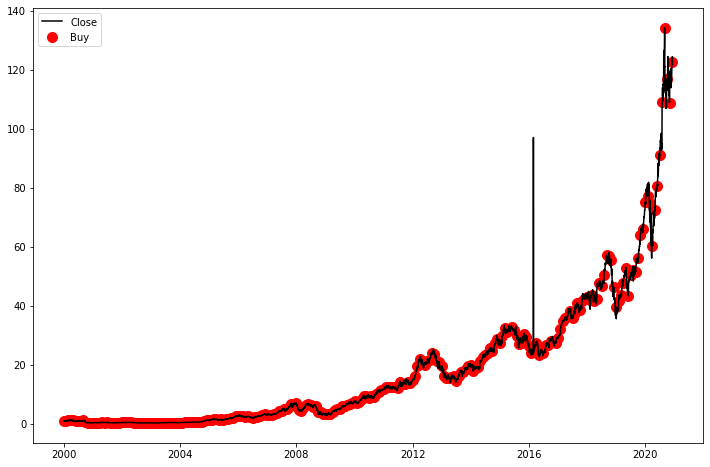

In [24]:
get_monthly_buy_by_price(symbol="AAPL", market="NASDAQ", start_date="2000-01-01", price_buy=1000000, show_graph=True, fig_save_path="result2")